# **Colorectal Cancer Detection**

In [2]:
import opendatasets as op

# Provide the correct URL for the dataset
url = "https://www.kaggle.com/datasets/livepriyanka09/warwick-gland-dataset"

# Use opendatasets.download to download the dataset
op.download(url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bkhinguyn
Your Kaggle Key: ········


100%|████████████████████████████████████████████████████████████████████████████████| 172M/172M [00:03<00:00, 56.5MB/s]


In [4]:
import os
if not os.path.exists('Warwick QU Dataset (Released 2016_07_08)'):
    !wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
    !unzip warwick_qu_dataset_released_2016_07_08.zip     

--2023-12-21 12:47:26--  https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 301 
Location: https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip [following]
--2023-12-21 12:47:27--  https://warwick.ac.uk/fac/cross_fac/tia/data/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Reusing existing connection to warwick.ac.uk:443.
HTTP request sent, awaiting response... 302 
Location: https://websignon.warwick.ac.uk/origin/slogin?shire=https%3A%2F%2Fwarwick.ac.uk%2Fsitebuilder2%2Fshire-read&providerId=urn%3Awarwick.ac.uk%3Asitebuilder2%3Aread%3Aservice&target=https%3A%2F%2Fwarwick.ac.uk%2Ffac%2Fcross_fac%2Ftia%2Fdata%2Fglascontest%2Fdownload%2Fwarwick_qu_dataset_released_2016_07_08.zip&status=n

### Import libraries

In [8]:
import os
import cv2
import glob
import torch
import shutil
import itertools
import torch.nn as nn
import torch.optim as optim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from torchvision.utils import make_grid
from PIL import Image
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Split training and test

In [2]:
data = pd.read_csv('Dataset/Grade.csv')
data.head()

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated


In [20]:
data.columns.tolist()

['name',
 'patient ID',
 ' grade (GlaS)',
 ' grade (Sirinukunwattana et al. 2015)']

### Use CLAHE to increase Contrast

In [21]:
input_directory = "Dataset/"
output_directory = "Dataset_high_contrast/"

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Iterate through each image file in the input directory
for file in os.listdir(input_directory):
    if file.endswith(".bmp"):
        # Read the color image
        image_path = os.path.join(input_directory, file)
        img = cv2.imread(image_path)

        # Convert the color space from BGR to LAB
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Split the LAB image into L, A, and B channels
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=40, tileGridSize=(8, 8))
        cl = clahe.apply(l)

        # Merge the CLAHE-enhanced L channel with the original A and B channels
        limg = cv2.merge((cl, a, b))

        # Convert the LAB image back to BGR
        clahe_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        # Save the processed image to the output directory
        output_path = os.path.join(output_directory, file)
        cv2.imwrite(output_path, clahe_img)

        
print("CLAHE applied to color images.")



CLAHE applied to color images.


In [22]:
import shutil

# Define the source directory containing your test images
source_directory = 'Dataset_high_contrast/'  # Replace with the actual path

# List all files in the source directory
file_list = os.listdir(source_directory)




In [23]:
# Define the destination directory (create it if it doesn't exist)
train_directory = "train"  # Replace with the actual path

# Filter the list to include only files with a specific prefix (e.g., "test")
train_files = [file for file in file_list if file.startswith("train") and not file.endswith("_anno.bmp")]

# Copy each train file to the destination directory
for file in train_files:
    # Remove the ".bmp" extension
    file_name, _ = os.path.splitext(file)
    
    source_path = os.path.join(source_directory, file)
    
    if data[data['name'] == file_name][' grade (GlaS)'].values[0] == ' benign':
        # Create a 'benign' subdirectory within the train directory if it doesn't exist
        destination_benign_path = os.path.join(train_directory, 'benign')
        os.makedirs(destination_benign_path, exist_ok=True)

        # Copy the file to the 'benign' subdirectory
        shutil.copy(source_path, destination_benign_path)
    else:
        # Create a 'benign' subdirectory within the train directory if it doesn't exist
        destination_malignant_path = os.path.join(train_directory, 'malignant')
        os.makedirs(destination_malignant_path, exist_ok=True)

        # Copy the file to the 'benign' subdirectory
        shutil.copy(source_path, destination_malignant_path)
        

In [24]:
# Define the destination directory (create it if it doesn't exist)
test_directory = "test"  # Replace with the actual path

# Filter the list to include only files with a specific prefix (e.g., "test")
test_files = [file for file in file_list if file.startswith("test") and not file.endswith("_anno.bmp")]

# Copy each train file to the destination directory
for file in test_files:
    # Remove the ".bmp" extension
    file_name, _ = os.path.splitext(file)
    
    source_path = os.path.join(source_directory, file)
    
    if data[data['name'] == file_name][' grade (GlaS)'].values[0] == ' benign':
        # Create a 'benign' subdirectory within the train directory if it doesn't exist
        destination_benign_path = os.path.join(test_directory, 'benign')
        os.makedirs(destination_benign_path, exist_ok=True)

        # Copy the file to the 'benign' subdirectory
        shutil.copy(source_path, destination_benign_path)
    else:
        # Create a 'benign' subdirectory within the train directory if it doesn't exist
        destination_malignant_path = os.path.join(test_directory, 'malignant')
        os.makedirs(destination_malignant_path, exist_ok=True)

        # Copy the file to the 'benign' subdirectory
        shutil.copy(source_path, destination_malignant_path)
        

### Visualize train and test set

<Axes: >

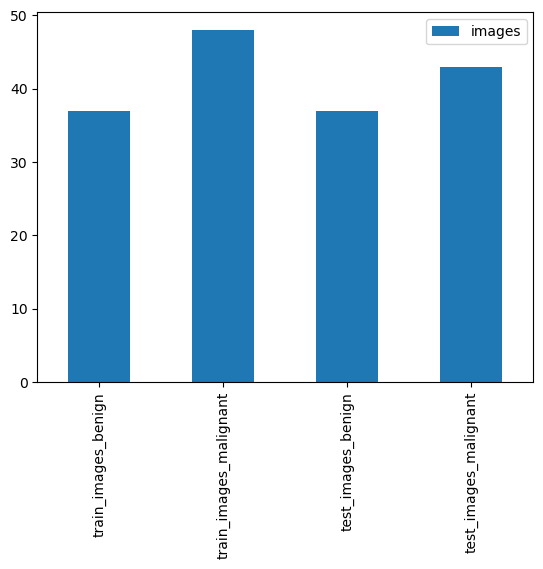

In [3]:
train_images_benign = len(os.listdir('train/benign'))
train_images_malignant = len(os.listdir('train/malignant'))             
test_images_benign = len(os.listdir('test/benign'))
test_images_malignant = len(os.listdir('test/malignant'))

data_info = pd.DataFrame(data = [train_images_benign,train_images_malignant,
                                 test_images_benign,test_images_malignant],
                         index = ['train_images_benign','train_images_malignant',
                                 'test_images_benign','test_images_malignant'],
                         columns = ['images'])

data_info.plot(kind='bar')

In [9]:
train_transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomResizedCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

val_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

data_dir = ''

train_dataset = ImageFolder(data_dir + 'train', train_transform)
val_dataset = ImageFolder(data_dir + 'test', val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=20, 
                              num_workers=2, sampler=ImbalancedDatasetSampler(train_dataset))

val_dataloader = DataLoader(val_dataset, batch_size=20, 
                              num_workers=2, sampler=ImbalancedDatasetSampler(val_dataset))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


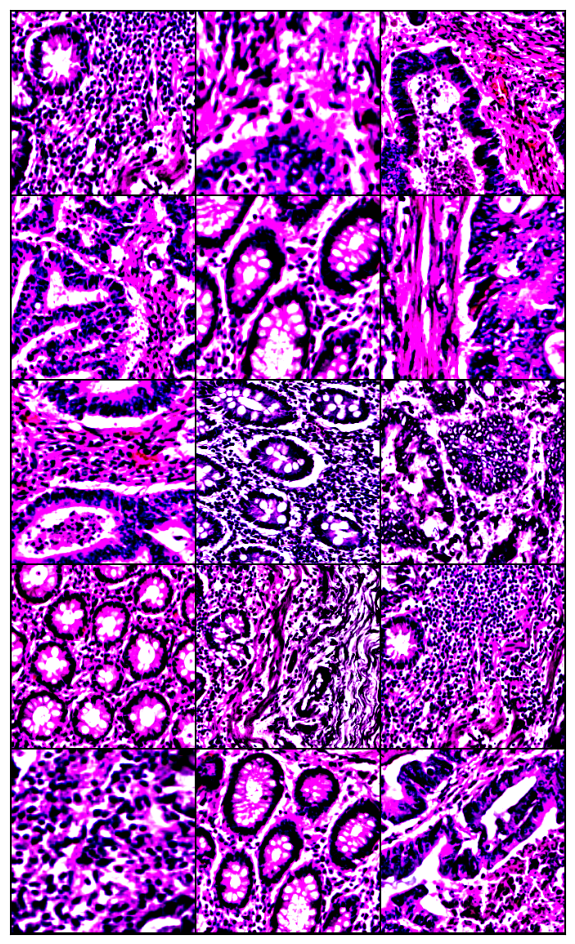

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:15], nrow=3).permute(1, 2, 0))
        break
        
show_batch(train_dataloader)

### Early Stopping

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
    
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Fit Function

In [24]:
def fit(model, batch_size, patience, n_epochs):
    

    avg_train_losses = []
    avg_valid_losses = [] 
    train_accuracy = []
    valid_accuracy = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):
        
        model.train()
        train_losses = []
        train_corrects = 0
        for batch, (data, target) in enumerate(train_dataloader, 1):
            
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
          
            output = model(data)
          
            loss = criterion(output, target)
            loss.backward()
          
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(output, 1)
            train_corrects += torch.sum(preds == target.data)

            train_losses.append(loss.item())

        train_acc = train_corrects.double() / len(train_dataset)
        train_accuracy.append(train_acc.item())
      
        model.eval()
        valid_losses = []
        valid_corrects = 0
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)
           
            output = model(data)
         
            loss = criterion(output, target)
            
            # Calculate accuracy
            _, preds = torch.max(output, 1)
            valid_corrects += torch.sum(preds == target.data)

            valid_losses.append(loss.item())

        valid_acc = valid_corrects.double() / len(val_dataloader.dataset)
        valid_accuracy.append(valid_acc.item())
        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print("Epoch: {}/{}, train_loss: {:4f}, val_loss: {:4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch, n_epochs, train_loss, valid_loss, train_acc, valid_acc))
        
        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model)
        
#         # Update learning rate using scheduler
#         scheduler.step(valid_loss)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses, train_accuracy, valid_accuracy


### Build Model

In [25]:
# Initiaizing ResNet50 Model
model = models.resnet50(pretrained=True)

# Freezing layers of resnet model so it won't be trained
for param in model.parameters():
    param.requires_grad = False

# Configuring fully connected layer to classify two classes
num_ftrs = model.fc.in_features        
model.fc = nn.Sequential(nn.Linear(num_ftrs, 2048),
                         nn.BatchNorm1d(2048),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(2048, 2))

print(model)

# Moving model to device(cpu or gpu)
model = model.to(device)

# Defining loss function
criterion = nn.CrossEntropyLoss()

# Defining optimizer
optimizer = optim.SGD(model.fc.parameters(),lr=0.001,momentum=0.5)  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Monitor Training time

In [26]:
from datetime import datetime

def timer(start_time=None):
  #function to track time
  if not start_time:
    print(datetime.now())
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Train model

In [27]:
start_time=timer(None)

model, train_loss, val_loss, train_acc, val_acc = fit(model, batch_size=16, patience=6, n_epochs=30)

timer(start_time)

2023-12-22 10:49:03.314747
Epoch: 1/30, train_loss: 0.766976, val_loss: 0.692711, train_acc: 0.4941, val_acc: 0.5500
Validation loss decreased (inf --> 0.692711).  Saving model ...
Epoch: 2/30, train_loss: 0.596601, val_loss: 0.654149, train_acc: 0.7176, val_acc: 0.7375
Validation loss decreased (0.692711 --> 0.654149).  Saving model ...
Epoch: 3/30, train_loss: 0.599564, val_loss: 0.648433, train_acc: 0.6941, val_acc: 0.5250
Validation loss decreased (0.654149 --> 0.648433).  Saving model ...
Epoch: 4/30, train_loss: 0.587451, val_loss: 0.597783, train_acc: 0.7294, val_acc: 0.6750
Validation loss decreased (0.648433 --> 0.597783).  Saving model ...
Epoch: 5/30, train_loss: 0.413172, val_loss: 0.579448, train_acc: 0.8118, val_acc: 0.7500
Validation loss decreased (0.597783 --> 0.579448).  Saving model ...
Epoch: 6/30, train_loss: 0.426429, val_loss: 0.509473, train_acc: 0.8000, val_acc: 0.8375
Validation loss decreased (0.579448 --> 0.509473).  Saving model ...
Epoch: 7/30, train_loss:

### Save Model

In [28]:
torch.save(model, 'ResNet50_Colorectal_Cancer.h5')

Let’s define some variables, transformations on test set(same as that of training set), softmax function to pick highest probability from model outputs.

In [29]:
TEST_BENIGN_PATH = 'test/benign/'
TEST_MALIGNANT_PATH = 'test/malignant/'
imsize = 224
thresh = 0.5  


test_loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

softmax = torch.nn.Softmax()
class_names = ['Benign','Malignant']

Now it’s time to analyze our model. For doing so we will define a function which will convert images to tensor for our model to work on.

Another thing we will define is the metrics to evaluate our model. We will not use accuracy as our metric as it is not ideal when dealing with imbalanced dataset. To understand why, let’s assume we have a dataset where there is 9 examples in Class A and 1 example in Class B. Now even if our model is poor, it has 90% chances of choosing correct class which means it can have 90% accuracy. It is obviously misleading in terms of analyzing our model. Thus we will use another pair of metric called sensitivity and specificity.

Sensitivity (also called the true positive rate, the recall) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition).

In [30]:
def image_to_tensor(image_name):
    image = Image.open(image_name).convert("RGB")
    image = test_loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 
    return image

def find_sens_spec(benign_prob, malignant_prob, thresh):
    sensitivity= (benign_prob >= thresh).sum()   / (len(benign_prob)+1e-10)
    specificity= (malignant_prob < thresh).sum() / (len(malignant_prob)+1e-10)
    print("sensitivity = %.3f, specificity = %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

In [31]:
model = torch.load('ResNet50_Colorectal_Cancer.h5', map_location='cpu') 
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Next up, we will use glob to convert test directory to a list, so that we can iterate over images in list and predict the class of each image.

In [32]:
test_benign  = glob.glob("%s*" %TEST_BENIGN_PATH)
test_malignant   = glob.glob("%s*" %TEST_MALIGNANT_PATH)

benign_predictions = np.zeros([len(test_benign),1]).astype(int)
malignant_predictions  = np.zeros([len(test_malignant),1]).astype(int)

benign_prob = np.zeros([len(test_benign),1])
malignant_prob   = np.zeros([len(test_malignant),1])

### Benign Test
For testing, original images were used.

In [33]:
for i in range(len(test_benign)):
    img = image_to_tensor(test_benign[i])
    output = model(img)
    _, pred = output.max(1, keepdim=True)
    prob = softmax(output)
    benign_prob[i,:]= prob.data.numpy()[0,0]
    print("{} Actual - Benign, Predicted - {} with probability - {}".format(i, class_names[int(pred.data.numpy())], prob.data.numpy()))

/home/bakhoin1/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 Actual - Benign, Predicted - Benign with probability - [[0.95545614 0.04454378]]
1 Actual - Benign, Predicted - Benign with probability - [[0.9573574  0.04264259]]
2 Actual - Benign, Predicted - Benign with probability - [[0.9775174  0.02248258]]
3 Actual - Benign, Predicted - Benign with probability - [[0.9664047  0.03359534]]
4 Actual - Benign, Predicted - Benign with probability - [[0.942144   0.05785597]]
5 Actual - Benign, Predicted - Benign with probability - [[0.7994355 0.2005645]]
6 Actual - Benign, Predicted - Benign with probability - [[0.9557848  0.04421523]]
7 Actual - Benign, Predicted - Benign with probability - [[0.991572 0.008428]]
8 Actual - Benign, Predicted - Benign with probability - [[0.8927394 0.1072606]]
9 Actual - Benign, Predicted - Benign with probability - [[0.798318   0.20168194]]
10 Actual - Benign, Predicted - Benign with probability - [[0.96685475 0.03314524]]
11 Actual - Benign, Predicted - Benign with probability - [[0.8246972 0.1753028]]
12 Actual - 

### Malignant Test

In [36]:
for i in range(len(test_malignant)):
    img= image_to_tensor(test_malignant[i])
    output= model(img)
    _, pred = output.max(1, keepdim=True)
    prob = softmax(output)
    malignant_prob[i,:]= prob.data.numpy()[0,0]
    print("{} Actual - Malignant, Predicted - {} with probability - {}".format(i, class_names[int(pred.data.numpy())], prob.data.numpy()))

0 Actual - Malignant, Predicted - Malignant with probability - [[0.41512802 0.58487207]]
1 Actual - Malignant, Predicted - Malignant with probability - [[0.01088583 0.98911417]]
2 Actual - Malignant, Predicted - Malignant with probability - [[0.14042923 0.8595708 ]]
3 Actual - Malignant, Predicted - Malignant with probability - [[0.32044247 0.67955756]]
4 Actual - Malignant, Predicted - Malignant with probability - [[0.09071448 0.9092855 ]]
5 Actual - Malignant, Predicted - Malignant with probability - [[0.21489057 0.7851094 ]]
6 Actual - Malignant, Predicted - Malignant with probability - [[0.42994425 0.5700558 ]]
7 Actual - Malignant, Predicted - Malignant with probability - [[0.08275204 0.917248  ]]
8 Actual - Malignant, Predicted - Malignant with probability - [[0.07185954 0.92814046]]
9 Actual - Malignant, Predicted - Malignant with probability - [[0.29350606 0.7064939 ]]
10 Actual - Malignant, Predicted - Malignant with probability - [[0.1035716  0.89642835]]
11 Actual - Malignan

### Calculate Sensitivity and Specificity

In [37]:
benign_predictions = np.where(benign_prob > thresh, 1, 0)
malignant_predictions = np.where(malignant_prob  > thresh, 1, 0)
    
sensitivity, specificity = find_sens_spec(benign_prob, malignant_prob, thresh)

sensitivity = 0.919, specificity = 0.953


### Plot confusion matrix

<Axes: >

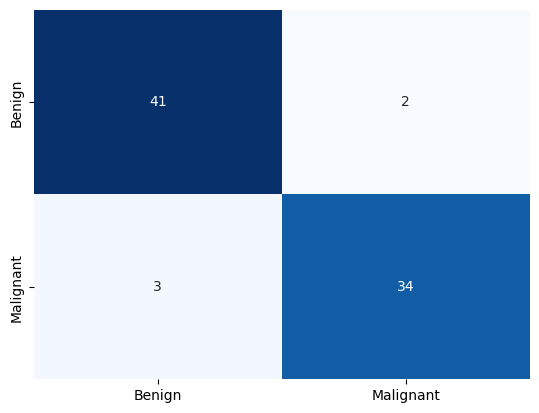

In [39]:
benign_list = [int(benign_predictions[i]) for i in range(len(benign_predictions))]
malignant_list = [int(malignant_predictions[i]) for i in range(len(malignant_predictions))]

y_pred_list = benign_list + malignant_list
y_test_list = [1 for i in range(len(benign_list))] + [0 for i in range(len(malignant_list))]

y_pred = np.asarray(y_pred_list, dtype=np.int64)
y_test = np.asarray(y_test_list, dtype=np.int64)

cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cnf_matrix, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Benign','Malignant'], yticklabels= ['Benign','Malignant'])

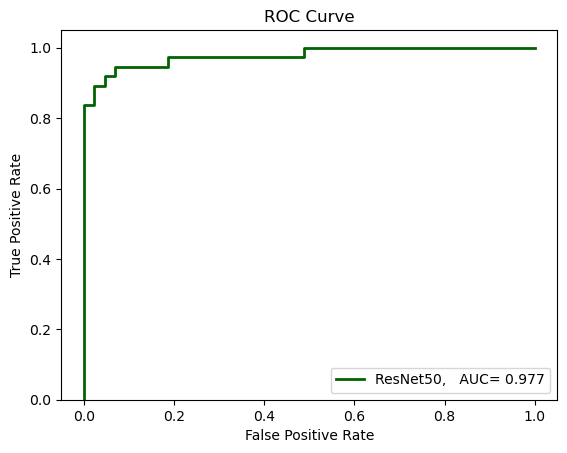

In [40]:
y_test_roc= [1 for i in range(len(benign_prob))]+[0 for i in range(len(malignant_prob))]
y_pred_roc= [benign_prob[i] for i in range(len(benign_prob))]+[malignant_prob[i] for i in range(len(malignant_prob))]

auc_score = roc_auc_score(y_test_roc, y_pred_roc)
false_postive_rate, true_positive_rate, _ = roc_curve(y_test_roc, y_pred_roc)

plt.figure()
plt.plot(false_postive_rate, true_positive_rate,  color='darkgreen', linewidth=2,   label='ResNet50,   AUC= %.3f' %auc_score)
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc='lower right')